In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
%matplotlib inline

In [2]:
import glob
import os
import cv2
from skimage import io,util
from tqdm import tqdm
from PIL import Image,ImageEnhance

In [7]:
dataDir = 'shuijing/*.png'
dataList = glob.glob(dataDir)

In [8]:
print(dataList[0])

shuijing/ImageA16S16A_10134_label.png


In [9]:
imageExample = dataList[0]
labelExample = dataList[0][:-4]+'_label.png'


In [10]:
image = io.imread(imageExample)
label = io.imread(labelExample)
imgH,imgW = image.shape
print("Image Size = {} * {}".format(imgH,imgW))

FileNotFoundError: [Errno 2] No such file or directory: 'shuijing/ImageA16S16A_10134_label_label.png'

In [ ]:
fig, ax = plt.subplots(1,2, sharey=True, figsize=(8,4))
ax[0].imshow(image, aspect="auto")
ax[1].imshow(label, aspect="auto")

In [11]:
def extract_patches_from_dir(directory, patchsize,stride):
    """
    Extract patches from an entire directory of images.
    """
    output = {}
    imageList = []
    for fname in os.listdir(directory):
        if fname[-4:] == '.png':
            outname = fname.split('.')[0]
            imageList.append(outname.split('_label')[0])
    imageList = set(imageList)
    for i in tqdm(imageList,desc='Patch generator progressing: ',total=len(imageList)):
        imageSet=[]
        imageName = os.path.join(directory,i+'.png')
        image = io.imread(imageName,as_grey=True)
        imgW,imgH = image.shape     
        labelName = os.path.join(directory,i+'_label.png')
        label = io.imread(labelName,as_grey=True)
        imagePatch= util.view_as_windows(image,window_shape=(patchsize,patchsize),step=stride)
        labelPatch= util.view_as_windows(label,window_shape=(patchsize,patchsize),step=stride)
        imageSet.append(imagePatch)
        imageSet.append(labelPatch)
        output[i]=np.array(imageSet)
    print("Get Patch Finish!!!!!!")
    return output

In [12]:
def save_patches(output,patchDstDir,imgW,imgH,threshold=0.01):
    for k,v in output.items():
        image = v[0]
        label = v[1]
        weightArray = image.shape[0]
        heightArray = image.shape[1]
        pixelNumber = int(imgW*imgH*threshold)
        for i in range(heightArray):
            for j in range(weightArray):
                if np.sum(label[j][i]>=1) > pixelNumber:
                    labelName = '_NG'
                    imageName = k + '_%s'%j+'_%s'%i+labelName+'.jpg'
                    imageSavePath = os.path.join(patchDstDir,'NG',imageName)
                    io.imsave(imageSavePath,image[j][i])
                
                else:
                    if(abs(np.random.normal(0,1))<0.3):
                        labelName = '_OK'
                        imageName = k + '_%s'%j+'_%s'%i+labelName+'.jpg'
                        imageSavePath = os.path.join(patchDstDir,'OK',imageName)
                        io.imsave(imageSavePath,image[j][i]) 
    return print("Saving patch done!")

In [13]:
def flip_image(dirpath):
    for filename in tqdm(os.listdir(dirpath),desc='Fliping {} Image :'.format(dirpath),total=len(os.listdir(dirpath))):
        imageName = os.path.join(dirpath,filename)
        name = filename.split('_')
        img = cv2.imread(imageName)
        horizontal_img = img.copy()
        vertical_img = img.copy()
        both_img = img.copy()
        horizontal_img = cv2.flip( img, 0 )
        horizontal_img = cv2.cvtColor(horizontal_img, cv2.COLOR_BGR2GRAY)
        vertical_img = cv2.flip( img, 1 )
        vertical_img = cv2.cvtColor(vertical_img, cv2.COLOR_BGR2GRAY)
        both_img = cv2.flip( img, -1 )
        both_img = cv2.cvtColor(both_img, cv2.COLOR_BGR2GRAY)
        if len(name) == 4:
            h_image_name= name[0]+'_'+name[1]+'_'+name[2]+'_'+'h'+'_'+name[3]
            v_image_name= name[0]+'_'+name[1]+'_'+name[2]+'_'+'v'+'_'+name[3]
            b_image_name= name[0]+'_'+name[1]+'_'+name[2]+'_'+'b'+'_'+name[3]
        elif len(name) == 5:
            h_image_name= name[0]+'_'+name[1]+'_'+name[2]+'_'+name[3]+'_'+'h'+'_'+name[4]
            v_image_name= name[0]+'_'+name[1]+'_'+name[2]+'_'+name[3]+'_'+'v'+'_'+name[4]
            b_image_name= name[0]+'_'+name[1]+'_'+name[2]+'_'+name[3]+'_'+'b'+'_'+name[4]
        elif len(name) == 6:
            h_image_name= name[0]+'_'+name[1]+'_'+name[2]+'_'+name[3]+'_'+'h'+'_'+name[4]+'_'+name[5]
            v_image_name= name[0]+'_'+name[1]+'_'+name[2]+'_'+name[3]+'_'+'v'+'_'+name[4]+'_'+name[5]
            b_image_name= name[0]+'_'+name[1]+'_'+name[2]+'_'+name[3]+'_'+'b'+'_'+name[4]+'_'+name[5]
        h_save_name=os.path.join(dirpath,h_image_name)
        v_save_name=os.path.join(dirpath,v_image_name)
        b_save_name=os.path.join(dirpath,b_image_name)
        cv2.imwrite(h_save_name,horizontal_img)
        cv2.imwrite(v_save_name,vertical_img)
        cv2.imwrite(b_save_name,both_img)

In [21]:
def rotate_image(dirpath):
    for filename in tqdm(os.listdir(dirpath),desc='Rotating {} Image :'.format(dirpath),total=len(os.listdir(dirpath))):
        imageName = os.path.join(dirpath,filename)
        name = filename.split('_')
        img = cv2.imread(imageName)
        rows,cols,channels = img.shape
        a = [90,180,270]
        for i in a:
            M = cv2.getRotationMatrix2D((cols/2,rows/2),i,1)
            dst = cv2.warpAffine(img,M,(cols,rows))
            dst = cv2.cvtColor(dst, cv2.COLOR_BGR2GRAY)
            if len(name) == 5:
                rotation_name = name[0]+'_'+name[1]+'_'+name[2]+'_'+name[3]+'_'+str(i)+'_'+name[4]
            elif len(name) == 6:
                rotation_name = name[0]+'_'+name[1]+'_'+name[2]+'_'+name[3]+'_'+name[4]+'_'+str(i)+'_'+name[5]
            else:
                rotation_name = name[0]+'_'+name[1]+'_'+name[2]+'_'+str(i)+'_'+name[3]
            cv2.imwrite(os.path.join(dirpath,rotation_name),dst)

In [15]:
def extract_patches_from_dir1(directory, patchsize=270,
                             stride=90,
                             ):
    """
    Extract patches from an entire directory of images.
    """
    output = {}
    imageList = []
    for fname in os.listdir(directory):
        if fname[-4:] == '.png':
            outname = fname.split('.')[0]
            imageList.append(outname.split('_label')[0])
    imageList = set(imageList)
    for i in tqdm(imageList,desc='Patch generator progressing: ',total=len(imageList)):
        imageSet=[]
        imageName = os.path.join(directory,i+'.png')
        image = io.imread(imageName,as_grey=True)
        labelName = os.path.join(directory,i+'_label.png')
        label = io.imread(labelName,as_grey=True)
        list = [[0,2700,0,540],[0,2700,2160,2700],[0,540,540,2160],[2160,2700,540,2160]]
        index = 0
        for j in list:
            image_crop = image[j[0]:j[1],j[2]:j[3]]
            label_crop = label[j[0]:j[1],j[2]:j[3]]
            imagePatch = util.view_as_windows(image_crop,window_shape=(patchsize,patchsize),step=stride)
            labelPatch = util.view_as_windows(label_crop,window_shape=(patchsize,patchsize),step=stride)
            imagePatch = np.reshape(imagePatch,(-1,patchsize,patchsize))
            labelPatch = np.reshape(labelPatch,(-1,patchsize,patchsize))

            if index == 0:
                imagePatches = imagePatch
                labelPatches = labelPatch
                pass
            else:
                imagePatches = np.append(imagePatches,imagePatch,axis=0)
                labelPatches = np.append(labelPatches,labelPatch,axis=0)
            index+=1

        imageSet.append(imagePatches)
        imageSet.append(labelPatches)
        output[i] = np.array(imageSet)
    return output

In [16]:
def save_patches1(output,patchDstDir):
    for k,v in output.items():
        image = v[0]
        label = v[1]
        numOfPatches = image.shape[0]
        for i in range(numOfPatches):
            if np.sum(label[i]>=1) > 729:
                labelName = '_NG'
                imageName = k+'_%s'%i+labelName+'.png'
                imageSavePath = os.path.join(patchDstDir,'NG',imageName)
                io.imsave(imageSavePath,image[i])
                
            else:
                if(abs(np.random.normal(0,1))<0.3):
                    labelName = '_OK'
                    imageName = k+'_%s'%i+labelName+'.png'
                    imageSavePath = os.path.join(patchDstDir,'OK',imageName)
                    io.imsave(imageSavePath,image[i])
    return print("Saving patch done!")

In [17]:
#patchDstDir = 'LensPatch01'
#imageSrcDir = 'lens/duanmian1024/'
patchDstDir = 'shuijingPatch01'
imageSrcDir = 'shuijing'

In [18]:
if not os.path.isdir(patchDstDir):
    os.mkdir(patchDstDir)
    os.mkdir(os.path.join(patchDstDir,'NG'))
    os.mkdir(os.path.join(patchDstDir,'OK'))

In [19]:
#patchsize = 256
#stride = 64
patchsize=270
stride = 90

In [20]:
#patches = extract_patches_from_dir(imageSrcDir,patchsize=patchsize,stride=stride)
#save_patches(patches,patchDstDir,imgW,imgH,threshold=0.01)
patches = extract_patches_from_dir1(imageSrcDir,patchsize=patchsize,stride=stride)
save_patches1(patches,patchDstDir)

Patch generator progressing:   0%|          | 0/256 [00:00<?, ?it/s]/home/shenshanlan/anaconda3/envs/tensorflow-1.8/lib/python3.5/site-packages/skimage/util/shape.py:247: RuntimeWarning: Cannot provide views on a non-contiguous input array without copying.
  warn(RuntimeWarning("Cannot provide views on a non-contiguous input "
Patch generator progressing: 100%|██████████| 256/256 [00:47<00:00,  5.43it/s]
/home/shenshanlan/anaconda3/envs/tensorflow-1.8/lib/python3.5/site-packages/skimage/io/_io.py:132: UserWarning: shuijingPatch01/OK/ImageA16S16A_10027_109_OK.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/shenshanlan/anaconda3/envs/tensorflow-1.8/lib/python3.5/site-packages/skimage/io/_io.py:132: UserWarning: shuijingPatch01/OK/ImageA16S16A_10027_221_OK.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/shenshanlan/anaconda3/envs/tensorflow-1.8/lib/python3.5/site-packages/skimage/io/_io.py:132: UserWarning: shuijingPatch01/OK/I

/home/shenshanlan/anaconda3/envs/tensorflow-1.8/lib/python3.5/site-packages/skimage/io/_io.py:132: UserWarning: shuijingPatch01/OK/ImageA16S16A_10081_221_OK.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/shenshanlan/anaconda3/envs/tensorflow-1.8/lib/python3.5/site-packages/skimage/io/_io.py:132: UserWarning: shuijingPatch01/OK/ImageA16S16A_10081_222_OK.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/shenshanlan/anaconda3/envs/tensorflow-1.8/lib/python3.5/site-packages/skimage/io/_io.py:132: UserWarning: shuijingPatch01/OK/ImageA16S16A_10072_110_OK.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/shenshanlan/anaconda3/envs/tensorflow-1.8/lib/python3.5/site-packages/skimage/io/_io.py:132: UserWarning: shuijingPatch01/OK/ImageA16S16A_10072_222_OK.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/shenshanlan/anaconda3/envs/tensorflow-1.8/lib/python3.5/site-packages/skim

/home/shenshanlan/anaconda3/envs/tensorflow-1.8/lib/python3.5/site-packages/skimage/io/_io.py:132: UserWarning: shuijingPatch01/OK/ImageA16S16A_10206_109_OK.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/shenshanlan/anaconda3/envs/tensorflow-1.8/lib/python3.5/site-packages/skimage/io/_io.py:132: UserWarning: shuijingPatch01/OK/ImageA16S16A_10212_222_OK.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/shenshanlan/anaconda3/envs/tensorflow-1.8/lib/python3.5/site-packages/skimage/io/_io.py:132: UserWarning: shuijingPatch01/OK/ImageA16S16A_10236_109_OK.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/shenshanlan/anaconda3/envs/tensorflow-1.8/lib/python3.5/site-packages/skimage/io/_io.py:132: UserWarning: shuijingPatch01/OK/ImageA16S16A_10263_223_OK.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/shenshanlan/anaconda3/envs/tensorflow-1.8/lib/python3.5/site-packages/skim

/home/shenshanlan/anaconda3/envs/tensorflow-1.8/lib/python3.5/site-packages/skimage/io/_io.py:132: UserWarning: shuijingPatch01/OK/ImageA16S16A_10136_110_OK.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/shenshanlan/anaconda3/envs/tensorflow-1.8/lib/python3.5/site-packages/skimage/io/_io.py:132: UserWarning: shuijingPatch01/OK/ImageA16S16A_10117_222_OK.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/shenshanlan/anaconda3/envs/tensorflow-1.8/lib/python3.5/site-packages/skimage/io/_io.py:132: UserWarning: shuijingPatch01/OK/ImageA16S16A_10215_108_OK.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/shenshanlan/anaconda3/envs/tensorflow-1.8/lib/python3.5/site-packages/skimage/io/_io.py:132: UserWarning: shuijingPatch01/OK/ImageA16S16A_10191_109_OK.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/shenshanlan/anaconda3/envs/tensorflow-1.8/lib/python3.5/site-packages/skim

/home/shenshanlan/anaconda3/envs/tensorflow-1.8/lib/python3.5/site-packages/skimage/io/_io.py:132: UserWarning: shuijingPatch01/OK/ImageA16S16A_10222_223_OK.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/shenshanlan/anaconda3/envs/tensorflow-1.8/lib/python3.5/site-packages/skimage/io/_io.py:132: UserWarning: shuijingPatch01/OK/ImageA16S16A_10057_223_OK.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/shenshanlan/anaconda3/envs/tensorflow-1.8/lib/python3.5/site-packages/skimage/io/_io.py:132: UserWarning: shuijingPatch01/OK/ImageA16S16A_10002_223_OK.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/shenshanlan/anaconda3/envs/tensorflow-1.8/lib/python3.5/site-packages/skimage/io/_io.py:132: UserWarning: shuijingPatch01/OK/ImageA16S16A_10207_221_OK.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/shenshanlan/anaconda3/envs/tensorflow-1.8/lib/python3.5/site-packages/skim

/home/shenshanlan/anaconda3/envs/tensorflow-1.8/lib/python3.5/site-packages/skimage/io/_io.py:132: UserWarning: shuijingPatch01/OK/ImageA16S16A_10254_223_OK.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/shenshanlan/anaconda3/envs/tensorflow-1.8/lib/python3.5/site-packages/skimage/io/_io.py:132: UserWarning: shuijingPatch01/OK/ImageA16S16A_10175_221_OK.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/shenshanlan/anaconda3/envs/tensorflow-1.8/lib/python3.5/site-packages/skimage/io/_io.py:132: UserWarning: shuijingPatch01/OK/ImageA16S16A_10175_223_OK.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/shenshanlan/anaconda3/envs/tensorflow-1.8/lib/python3.5/site-packages/skimage/io/_io.py:132: UserWarning: shuijingPatch01/OK/ImageA16S16A_10042_2_OK.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/shenshanlan/anaconda3/envs/tensorflow-1.8/lib/python3.5/site-packages/skimag

/home/shenshanlan/anaconda3/envs/tensorflow-1.8/lib/python3.5/site-packages/skimage/io/_io.py:132: UserWarning: shuijingPatch01/OK/ImageA16S16A_10247_222_OK.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/shenshanlan/anaconda3/envs/tensorflow-1.8/lib/python3.5/site-packages/skimage/io/_io.py:132: UserWarning: shuijingPatch01/OK/ImageA16S16A_10208_109_OK.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/shenshanlan/anaconda3/envs/tensorflow-1.8/lib/python3.5/site-packages/skimage/io/_io.py:132: UserWarning: shuijingPatch01/OK/ImageA16S16A_10170_223_OK.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/shenshanlan/anaconda3/envs/tensorflow-1.8/lib/python3.5/site-packages/skimage/io/_io.py:132: UserWarning: shuijingPatch01/OK/ImageA16S16A_10143_109_OK.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/shenshanlan/anaconda3/envs/tensorflow-1.8/lib/python3.5/site-packages/skim

/home/shenshanlan/anaconda3/envs/tensorflow-1.8/lib/python3.5/site-packages/skimage/io/_io.py:132: UserWarning: shuijingPatch01/OK/ImageA16S16A_10139_222_OK.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/shenshanlan/anaconda3/envs/tensorflow-1.8/lib/python3.5/site-packages/skimage/io/_io.py:132: UserWarning: shuijingPatch01/OK/ImageA16S16A_10183_223_OK.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/shenshanlan/anaconda3/envs/tensorflow-1.8/lib/python3.5/site-packages/skimage/io/_io.py:132: UserWarning: shuijingPatch01/OK/ImageA16S16A_10242_108_OK.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/shenshanlan/anaconda3/envs/tensorflow-1.8/lib/python3.5/site-packages/skimage/io/_io.py:132: UserWarning: shuijingPatch01/OK/ImageA16S16A_10242_222_OK.png is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/shenshanlan/anaconda3/envs/tensorflow-1.8/lib/python3.5/site-packages/skim

Saving patch done!


In [22]:
flip_image(os.path.join(patchDstDir,'NG'))
rotate_image(os.path.join(patchDstDir,'NG'))
flip_image(os.path.join(patchDstDir,'OK'))

Fliping shuijingPatch01/OK Image :: 100%|██████████| 19813/19813 [02:04<00:00, 158.54it/s]


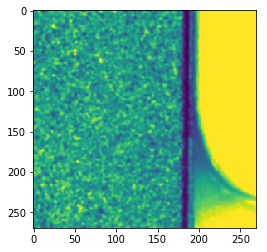

In [24]:
NGDir = 'shuijingPatch01/OK/*.png'
NGList = glob.glob(NGDir)

image = io.imread(NGList[3])
fig, ax = plt.subplots(1,1, sharey=True, figsize=(4,4))
ax.imshow(image, aspect="auto")